# Heart rate estimation, signal de-noising and mobile health
The goal of this lab is to study an algorithm for correctly retrieving the timing instants of an ECG (EKG) time series. We will implement a simplified variant of the [Pan-Tompkins algorithm](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=4122029) and we will test it on real ECG data recordings. Towards the end of the lab you will be asked to apply your algorithms to the problem of heart rate estimation using a mobile device.

### Objectives
By the end of this session you should be able to understand the main challenges in the estimation of EGC signals. How to work from modeling assupmtions in order to exploit your prior knowledge in the estimation task.

* _Note: Everything below this line should be truned in as part of your lab report._

***

### Signal generation and template matching
In this task we will implement a simple version of a QRS-complex detector by using template matching, thresholding and non-maximum suppresion on the
observed ECG signal. We will then use those detections to provide an estimate of the heart rate.

* **Signal Generation -** We are going to create a synthetic EGC signal that we will be using to test our detector algorithm. For that purpose generate a stream of $10$ equally spaced pulses over a time span of $10\ s$ and with a sampling rate of $f_s = 256\ Hz$. The goal of this task is to create a basic model for a ECG signal. You can think of the signal as the convolution of a canonical pulse shape $\varphi(t)$ with a stream of Dirac delta functions: 

   $$x(t) = \sum_{k=1}^K a_k\, \varphi(t-t_k) = \varphi(t) \ast \sum_{k=1}^K a_k\, \delta(t-t_k),$$ 

   where $K$ is the number of pulses observed, $a_k$ represent the amplitudes of the different pulses and $t_k$ correspond to the locations of the pulses in time. For the purpose of this task use the canonical pulse shape generated by the `ecg_wave()` function defined in the notebook and constant unit amplitudes $a_k=1$. Plot the generated signal over time adding the appropriate labels for the axis.


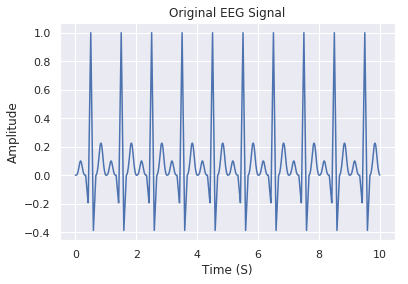

In [0]:
# ============================================================================
# import modules
# ============================================================================
# Note that this part of the code needs to be run prior to any other code cell

# Casey Weiner, Eric Han

import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal

# inline plots
%matplotlib inline
sns.set()

# ============================================================================
# functions
# ============================================================================
def ecg_wave(x):
    """
    This function generates a synthetic ECG template of unit length (support).

    """
    
    # compute signal (superposition of splines)
    return 0.3 * signal.bspline(3*3*x-7.5,2)\
         + 0.15* signal.bspline(3*4*x-2,3)\
         + signal.bspline(3*2*2*x-6,1) - 0.2 * signal.bspline(3*4*x-5,1) - 0.4 * signal.bspline(3*4*x-7,1)


# ============================================================================
# Start your code below this line
# ============================================================================
N = 256
t = np.arange(N) / N # This is the number of samples in one second, which is 
#the length of one period in the graph. The graph over one period is required 
#for the convolution to yield all 10 complete periods.

# This shifts the peaks to start at half a second. 
sum = [0]*(N*10)
for i in range(1,11):
  sum[i*256 - 128] = 1

# Creates template for later template matching
template = ecg_wave(t)

#Plotting The 10 Periods
plt.figure()
newoutput = np.convolve(sum,ecg_wave(t),'same')
plt.plot(np.linspace(0,10,len(newoutput)),newoutput)
plt.xlabel('Time (S)')
plt.ylabel("Amplitude")
plt.title('Original EEG Signal')

# Creates two copies of the signal to use in later tasks.
x = np.convolve(sum,ecg_wave(t),'same')
original = np.convolve(sum,ecg_wave(t),'same')

* **Simulate Noise -** Generate a noisy version of the synthetic ECG signal generated before by adding Gaussian noise with standard deviation $\sigma=0.5$. Plot the noisy observations. Can you identify the locations of the QRS-complex?

Text(0.5, 1.0, 'Noisy Signal')

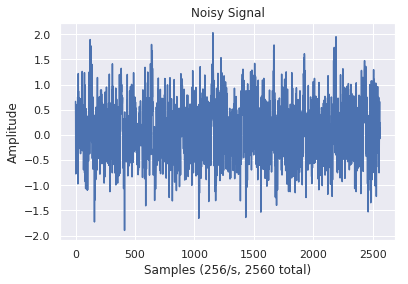

In [0]:
# Casey Weiner, Eric Han

np.random.seed(10)

val = len(x) # Length of signal

noise = [0] * val
for i in range(val):
  noise[i] = 0.5*np.random.randn() # Creates a vector of noise 
# that is the same length as the signal.
  
xnoise = x + noise #Adds noise to the signal
plt.plot(xnoise)
plt.xlabel('Samples (256/s, 2560 total)')
plt.ylabel('Amplitude')
plt.title('Noisy Signal')

#No, I cannot idenify the locations of the QRS-complex.
#The noise is too large.

* **Find Peaks -** Implement a QRS-complex detector on the noisy signal you just generated. For that purpose we will use template matching, thresholding, and non-maximum suppression. We recommend that you normalize the signal before thresholding. For instance, you can normalize the signal to take values in the range $[0,1]$ or you could standardize the signal by making it zero mean and unit variance. After normalization define a threshold value and keep only those values of the signal that are above the given threshold. Once you have done that, perform a non-maximum suppression (i.e., keep a value if it is greater than the previous and following values). To implement the thresholding and non-maximum suppression operations you can use `signal.find_peaks` function.

Text(0.5, 1.0, 'Noisy Signal Template Matched and Normalized')

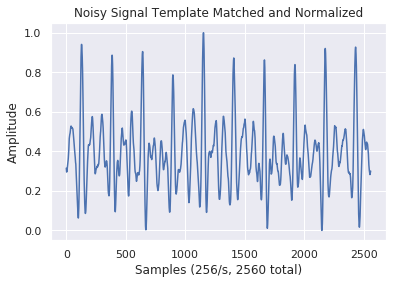

In [0]:
# Casey Weiner, Eric Han

def normalize_range(x):
    """
    Normalizes the signal such that its minimum value is 0 and its maximum value is 1,
    provided the signal is not identically zero.
    """
    # check that there are non-zero elements
    if np.any(x):
        
        # subtract minimum
        minx = np.min(x)
        z = x - minx
        
        # divide by max value
        maxz = np.max(z)
        return z/maxz
    
    else:
        
        return x


xcorr = np.correlate(xnoise,template,'same') # Template matching with correlation.
xnorm = normalize_range(xcorr) # Normalizes the template-matched x.
input, _ = signal.find_peaks(xnorm,height=0.75) # Finds the indices of the peaks
# of the template matched and normalized x.

#Plotting Template-Matched and Normalized Noisy Signal
plt.figure()
plt.plot(xnorm)
plt.xlabel('Samples (256/s, 2560 total)')
plt.ylabel('Amplitude')
plt.title('Noisy Signal Template Matched and Normalized')



* **RR Intervals -** Plot the original (synthetic) ECG signal as well as the locations of the peaks to verify your method. Keep in mind to compensate for any delay you might have introduced by filtering. From the peak binary signal, estimate the $RR$ interval sequence $r_n$ and its average value as:

$$ \bar R = \frac{1}{N}\sum_{n=0}^N r_n, $$

where $N$ is the number of peaks detected. Provide an estimate of the average heart beat rate in beats per minute $[bpm]$.


RR intervals with average RR interval
[257 256 255 257 255 258 256 255 255]
256.0
BPM Estimate:
60.0


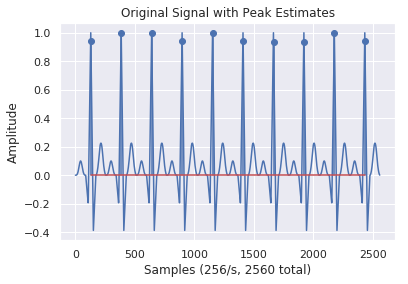

In [0]:
# Casey Weiner, Eric Han

#Plotting original signal and estimates of the locations of original peaks.
plt.plot(original)
plt.stem(input,original[input])
plt.xlabel('Samples (256/s, 2560 total)')
plt.ylabel('Amplitude')
plt.title('Original Signal with Peak Estimates')

#The filtering done to get back from the noisy signal is the reason why the dots
#are not exactly on the tops of the peaks.

#RR-interval sequence, average value, and bpm estimations
RRintervals = np.diff(input)
RRmean = np.mean(RRintervals)
bpm = RR * 60 / N 

print("RR interval sequence with average RR interval below:")
print(RRintervals)
print(RRmean)
print("BPM Estimate:")
print(bpm)

# Since there is one pulse every second,
# that means there is a heart beat every second.
# This works out to exactly 60bpm.



### QRS complex detection via Pan-Tompkins algorithm
Now let us consider a more realistic scenario where we have a noisy ECG signal where we don't know a priori the shape of the QRS-complex waeform. There are different
sources of noise that can be present during an ECG acquisition. In addition to high-frequency thermal
noise, it is also common to observe the presence of low-frequency interference coming from breathing. 
When it comes to pathologies, different non-additive distortions might be present on the ECG signal 
that alter the shape of the QRS-complex itself but for the purpose of this task we just assume a healthy 
individual where signal distortion comes solely from the acquisition process. The procedure that we
will employ in order to estimate the locations of the QRS-complex is based on the Pan-Tompkins
algorithm [Pan-Tompkins algorithm](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=4122029).

* **Effect of noise** - Load the signal **ecg_mitnst.json** and plot the signal over time. The signal corresponds to a sample ECG from the [MIT noise stress dataset](https://physionet.org/physiobank/database/nstdb/)
that has been downloaded from [physionet.org](https://physionet.org/physiobank/database/).
Plot the signal and observe the presence of a strong low-frequency component.

In [0]:
# access files stored on Google Drive from Colab
from google.colab import drive
drive.mount('gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at gdrive/


{'fs': 360, 'time': [0.0, 0.002777777777777778, 0.005555555555555556, 0.008333333333333333, 0.011111111111111112, 0.013888888888888888, 0.016666666666666666, 0.019444444444444445, 0.022222222222222223, 0.025, 0.027777777777777776, 0.030555555555555555, 0.03333333333333333, 0.03611111111111111, 0.03888888888888889, 0.041666666666666664, 0.044444444444444446, 0.04722222222222222, 0.05, 0.05277777777777778, 0.05555555555555555, 0.058333333333333334, 0.06111111111111111, 0.06388888888888888, 0.06666666666666667, 0.06944444444444445, 0.07222222222222222, 0.075, 0.07777777777777778, 0.08055555555555556, 0.08333333333333333, 0.08611111111111111, 0.08888888888888889, 0.09166666666666666, 0.09444444444444444, 0.09722222222222222, 0.1, 0.10277777777777777, 0.10555555555555556, 0.10833333333333334, 0.1111111111111111, 0.11388888888888889, 0.11666666666666667, 0.11944444444444445, 0.12222222222222222, 0.125, 0.12777777777777777, 0.13055555555555556, 0.13333333333333333, 0.1361111111111111, 0.13888

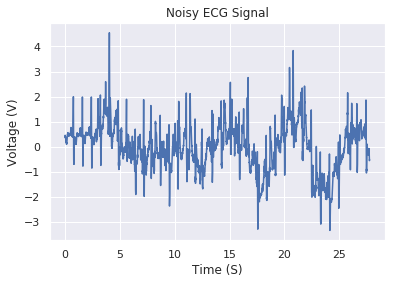

In [0]:
# Casey Weiner, Eric Han

# load data from Google Drive
with open('gdrive/My Drive/bmdslab/lab-01/ecg_mitnst.json','r') as infile:
    data = json.load(infile)

    # print data to see dictionary fields
    
    print(data)
    
    # normalize voltage so it is centered around zero, find tk values for later
    voltage = data['voltage']
    time = data['time']
    voltage = voltage - np.mean(voltage)
    gtruth = data['tk']
    
    # plot signal
    plt.plot(time,voltage)
    plt.title('Noisy ECG Signal')
    plt.xlabel('Time (S)')
    plt.ylabel('Voltage (V)')
    
    #The frequency is visibly low in the plot.
    

* **Pan-Tompkins Algorithm -** In order to deal with noise we will implement a simplified version of the Pan-Tompkins algorithm. For that purpose proceed as follows:

  1. _Bandpass filtering:_ Follow the steps described in the manual in order to perform a bandpass filtering operation as the concatenation of lowpass and highpass filtering operations. Display the obtained signals at the intermediate steps.
  
  2. _Differentiation:_ Use the discrete filter $d_n$ to approximate the derivative of the underlying signal:
  
    $$ d_n = \frac{1}{8}\big(\delta_{n-2} + 2\delta_{n-1} -2\delta_{n+1} - \delta_{n+2}\big) $$
  
    The filter is intended to localize the steepest region in the QRS-complex.
  
  3. _Signal squaring:_ Square the obtained signal after differentiation and plot the obtained waveform. On the squared signal use an averaging filter of length $L=20$. Why was squaring helpful in revealing the peaks of the QRS complex?
  
  3. _Integration:_ Integrate the resulting signal from the squaring operation with a box window of length $L=50$. Display the resulting signal.
  
  4. _Peak detection:_ Use a peak detector to reveal the locations of the peaks. Estimate the average $RR$ interval and plot the sequence of estimated peaks.
 

Estimated RR interval sequence with average RR interval below:
[72.72727273 73.97260274 72.97297297 74.22680412 75.         76.32508834
 76.05633803 78.54545455 88.88888889 70.35830619 75.78947368 73.72013652
 78.54545455 75.78947368 92.30769231 64.67065868 72.72727273 71.76079734
 74.74048443 77.69784173 69.90291262 74.74048443 71.05263158 72.48322148
 75.52447552 73.22033898 71.28712871 71.28712871 72.         75.52447552
 70.58823529 70.81967213 72.97297297]
74.49171794437369
RR distance is about
74.19589882377433
Both the average of the RR interval sequence and the average difference in peaks converted to RR are included, in that order.


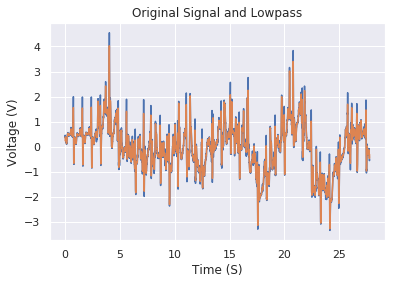

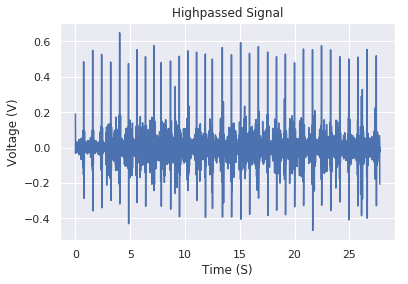

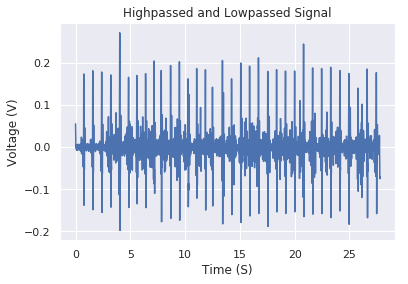

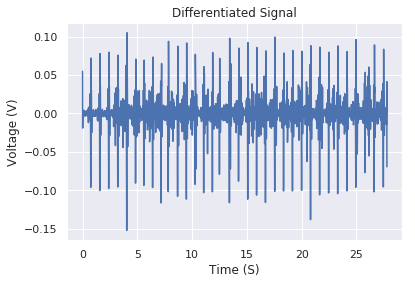

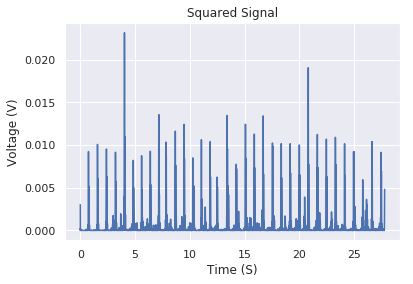

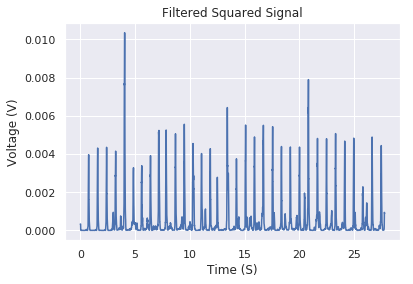

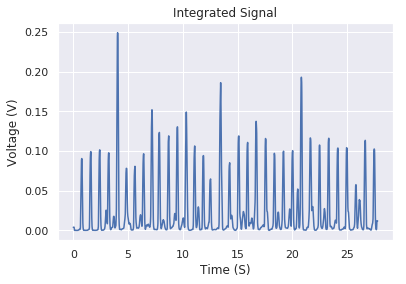

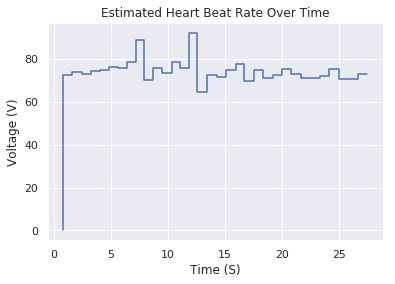

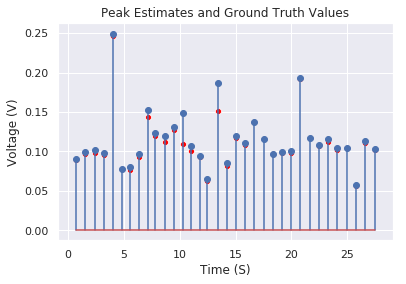

In [0]:
# Casey Weiner, Eric Han

signal = voltage

#Bandpass Filtering

box = np.ones(7) #7 was chosen because this and 14 are between 5 and 15 Hz
box = box/np.sum(box)
box10 = np.ones(10)
box10 = box10/np.sum(box10)
triangle = np.convolve(box,box)
triangle = triangle/np.sum(triangle)

signal = signal - np.mean(signal) #Normalizing around 0

plt.figure()
plt.title('Original Signal and Lowpass')
plt.xlabel('Time (S)')
plt.ylabel('Voltage (V)')
plt.plot(time,signal) #Shown in Blue

#High pass
signal_lf = np.convolve(signal,triangle,'same')

plt.plot(time,signal_lf) #Shown in Orange

signal_highpass = signal - signal_lf

plt.figure()
plt.title('Highpassed Signal')
plt.xlabel('Time (S)')
plt.ylabel('Voltage (V)')
plt.plot(time,signal_highpass)

#Low pass of the high pass
signal_highandlow = np.convolve(signal_highpass,box10,'same')

plt.figure()
plt.title('Highpassed and Lowpassed Signal')
plt.xlabel('Time (S)')
plt.ylabel('Voltage (V)')
plt.plot(time,signal_highandlow)

#Differentiation

signaldiff = signal_highandlow
for i in range(2,len(signal_highandlow) - 2):
  signaldiff[i] = (1/8)*(float(signal_highandlow[i - 2]) + 2*float(signal_highandlow[i - 1])  - 2*float(signal_highandlow[i + 1]) - float(signal_highandlow[i + 2]))

#Plotting
plt.figure()
plt.title("Differentiated Signal")
plt.xlabel('Time (S)')
plt.ylabel('Voltage (V)')
plt.plot(time,signaldiff)  
  
#Squaring

signalsquare = signaldiff
signalsquare = [i ** 2 for i in signalsquare]

#Plotting
plt.figure()
plt.title("Squared Signal")
plt.xlabel('Time (S)')
plt.ylabel('Voltage (V)')
plt.plot(time,signalsquare)

newfilter = np.ones(20)
newfilter = newfilter/np.sum(newfilter)

signalsquareaverage = np.convolve(signalsquare,newfilter,'same')

#Plotting
plt.figure()
plt.title("Filtered Squared Signal")
plt.xlabel('Time (S)')
plt.ylabel('Voltage (V)')
plt.plot(time,signalsquareaverage)

#Squaring makes all of the peaks positive and taller so it is easier to find
#all of them.

#Integration

intfilter = np.ones(50) #This filter not averaged. "Box window" does not mean
#average, according to TA. Integrating means just use box.
signalintegrate = np.convolve(signalsquareaverage,intfilter,'same')

#Plotting
plt.figure()
plt.title("Integrated Signal")
plt.xlabel('Time (S)')
plt.ylabel('Voltage (V)')
plt.plot(time,signalintegrate)

#Peak Detection

inputnew, _ = sp.signal.find_peaks(normalize_range(signalintegrate),height = 0.19,distance = 200) #Again made sure to normalize before finding the threshold value
newdiff = np.diff(inputnew)

#RRinterval estimate  
RRlist = (60 * data['fs']) / newdiff
print("Estimated RR interval sequence with average RR interval below:")
print(RRlist)
print(np.mean(RRlist)) # Average RR

zero = 0
RRlist = np.insert(RRlist, 0, 0) # 0 is appended so that the heart rate at zero
# considered 0 as well as whatever value is calculated. This makes the most
# real-life sense: a heartbeat appears instantly from zero when it is measured.
# Before the first heartbeat, none are registered.
xin = inputnew / data['fs']

#Plotting of Estimated Heart Rate Over Time
plt.figure()
plt.step(xin,RRlist)
plt.xlabel('Time (S)')
plt.ylabel('Voltage (V)')
plt.title('Estimated Heart Beat Rate Over Time')
m = np.mean(newdiff)
RR = (60 * data['fs']) / m #Average diff converted to RR
print("RR distance is about")
print(RR) 
print("Both the average of the RR interval sequence and the average difference in peaks converted to RR are included, in that order.")

#Find time values for peaks
in_put = [0]*(len(gtruth))
count = 0
for i in gtruth:
  in_put[count] = time[i] 
  count = count + 1

#Plotting Estimated Peaks
plt.figure()
plt.title("Peak Estimates and Ground Truth Values")
plt.xlabel('Time (S)')
plt.ylabel('Voltage (V)')
plt.stem(in_put,signalintegrate[inputnew])
sns.scatterplot(in_put,signalintegrate[gtruth],color='red') #Shown in red

#Discrepancy between estimates of peaks and the ground truth 
#is explained by all of the filtering steps we went through. Those interefere
#with the original makeup of the signal, making the estimates slightly off.

### Mobile health
In this last task we will consider the estimation of the heart rate in a less controlled scenario. In this case,
the signal comes from a mobile device and it is not a one-dimensional time-series but a video recording. Those with a
smartphone can record and use their own signals for the experiment. Alternatively, you can use the video
provided for that purpose. The recorded signal consists of a video of the tip of the finger placed
right in front of the camera while the camera flash is on. Play this video on your notebook and try to observe
the intensity variations due to the heart beat.

* Using the video signal and the methods studied in previous sections estimate the average heart rate from it.



In [0]:
import io
import base64
from IPython.display import HTML

# this code displays the video
video = io.open('gdrive/My Drive/bmdslab/lab-01/ppg_resized.mp4', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))

28.580645161290324
52.48306997742663
[85.91581726 85.91011556 85.92913818 85.7506663  85.43688965 85.44276428
 85.3270874  85.3854777  85.31997172 85.31708272 85.74404907 85.63733419
 85.70082601 85.82476298 85.81651815 85.84606425 85.74838257 85.76989746
 85.86339823 85.89480082 85.99417114 85.56725566 84.18318176 82.90947469
 81.62532043 80.69060262 79.98575338 79.52865092 79.32934062 78.8309021
 78.77394613 78.7561086  78.99522909 79.41820272 79.60726929 79.99894714
 80.47110494 81.0680898  81.10425822 81.50248718 81.90600586 81.95304362
 82.24655151 82.24921672 82.29056803 82.46189372 82.75818888 82.81708272
 82.58943685 81.43703715 80.3473053  79.67246501 79.54600016 79.2482961
 79.23756917 79.80111694 80.43324788 80.56917826 80.76433309 80.76813761
 81.1462911  81.18893433 81.61965434 81.87173462 82.0537974  82.24190776
 82.43617249 82.61129252 82.77355448 82.91046651 83.00205485 83.15135701
 83.41575114 83.59792074 82.94719442 82.67234294 81.57729594 80.21524048
 79.48973083 79.

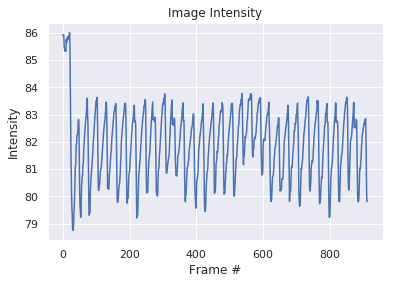

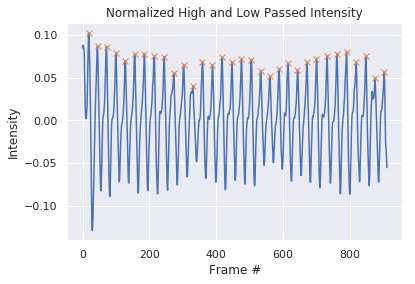

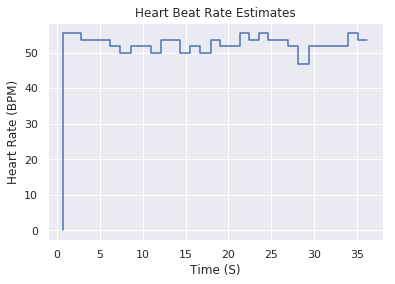

In [0]:
# Casey Weiner, Eric Han

import cv2

# create video reader object
vread = cv2.VideoCapture("gdrive/My Drive/bmdslab/lab-01/ppg_resized.mp4")

# get number of frames
nframes = int(vread.get(cv2.CAP_PROP_FRAME_COUNT))

# get frame rate
fps = vread.get(cv2.CAP_PROP_FPS)

framearray = np.zeros(nframes)
# loop over frames
for ff in range(nframes):
    # read frames
    ret, img = vread.read()
    framearray[ff] = np.mean(img) #Measuring average image intensity. Intensity peaks will be present after each heart beat.

#Proposed method: read in the intensities of the images, in terms of the rbg values at each pixel.
#Spikes in intensity show the end of a heartbeat, because when a heartbeat occurs the picture becomes dark and the light again.
#Take those signal readings from the images, then send through same basic pre-processing steps, and finally find peaks and then calculate
#heartbeat from that.
    
plt.figure()
plt.title("Image Intensity")
plt.xlabel('Frame #')
plt.ylabel('Intensity')
plt.plot(framearray)

#Send array through each of the same preprocessing steps:

#normalize

framenorm = normalize_range(framearray)

#bandpass

box = np.ones(10)
box = box/np.sum(box)
triangle = np.convolve(box,box)
triangle = triangle/np.sum(triangle)

framenorm = framenorm - np.mean(framenorm)
framenorm_lf = np.convolve(framenorm,triangle,'same')

framenorm_highpass = framenorm - framenorm_lf
framenorm_highandlow = np.convolve(framenorm_highpass,box,'same')

#find peaks

plt.figure()
plt.plot(framenorm_highandlow)
plt.title("Normalized High and Low Passed Intensity")
plt.xlabel('Frame #')
plt.ylabel('Intensity')
inputfinal, _ = sp.signal.find_peaks(framenorm_highandlow,height = 0,distance = 20)

#plot bpm as a step plot

plt.plot(inputfinal,framenorm_highandlow[inputfinal],"x")

diff = np.diff(inputfinal)
RR = np.mean(diff)
bpm = fps * 60 / RR 
diff = fps * 60 / diff

plt.figure()
plt.title("Heart Beat Rate Estimates")
plt.xlabel('Time (S)')
plt.ylabel('Heart Rate (BPM)')
diff = np.insert(diff, 0, 0) #Zeros appended for same reason as earlier
xinfinal = inputfinal / fps
plt.step(xinfinal,diff)

print(RR)
print(bpm)


print(framearray)